In [1]:
import tensorflow as tf
import numpy as np
import imageio
import matplotlib.pyplot as plt
%matplotlib inline

config = tf.ConfigProto(gpu_options=tf.GPUOptions(visible_device_list="1", allow_growth=True))

# load a color image with missing entries
img = imageio.imread('Lena_ms70_binary(1or255).png')

N1 = img.shape[0]
N2 = img.shape[1]
C  = 1
N3 = 1

tau = 6 # window size of delay embedding (patch size)
r   = 10 # dimension of manifold
sig = 1.0/20.0 # noise level for denoising auto-encoder


In [2]:
# define functions

# making one-hot filters
def make_embfilter(tau):
    fil = np.zeros([tau,tau,1,tau*tau])
    tij = 0
    for ti in range(tau):
        for tj in range(tau):
            fil[ti,tj,0,tij] = 1
            tij = tij+1
    return fil
Hfil = make_embfilter(tau)
Hfil = Hfil.astype('float32')

pad_para_emb   = [[0,0],[tau-1,tau-1],[tau-1,tau-1],[0,0]]
pad_type_emb   = 'symmetric'

# delay-embedding layer
def H(z):
    z = tf.pad(z,pad_para_emb,pad_type_emb)
    return tf.nn.conv2d(z,Hfil,strides=[1,1,1,1],padding='VALID')

# inverse delay-embedding layer
def Hinv(z):
    z_size = np.array(z.shape,dtype='int32')
    Htz = tf.nn.conv2d_transpose(z,Hfil,output_shape=[z_size[0],
                                                      z_size[1]+tau-1,
                                                      z_size[2]+tau-1,
                                                      Hfil.shape[2]],strides=[1,1,1,1],padding='VALID')
    return Htz[:,tau-1:z_size[1],tau-1:z_size[2],:]/tau/tau


## autoencoder
def NN(data,ranks):
    Z0 = tf.layers.dense(data,ranks[0])
    Z0 = tf.nn.leaky_relu(Z0)
    Z1 = tf.layers.dense(Z0,ranks[1])
    Z1 = tf.nn.leaky_relu(Z1)
    Z2 = tf.layers.dense(Z1,ranks[2])
    Z2 = tf.nn.leaky_relu(Z2)
    Z3 = tf.layers.dense(Z2,ranks[3])
    Z3 = tf.nn.leaky_relu(Z3)
    Z4 = tf.layers.dense(Z3,ranks[4])
    Z4 = tf.nn.leaky_relu(Z4)
    Z5 = tf.layers.dense(Z4,data.shape[1])
    return Z5

In [3]:
## problem def

#dimensions of intermediate layers in denoising auto-encoder 
ranks = [tau*tau, tau*tau, r, tau*tau, tau*tau]

X = tf.Variable(tf.random_uniform([C,N2,N1,1], dtype=tf.float32))
Hx=tf.transpose(tf.reshape(tf.transpose(H(X)),[tau*tau,C*(N2+tau-1)*(N1+tau-1)]))
noise= tf.random_normal(Hx.shape,0.0,sig,dtype=tf.float32)
AHx  = NN(Hx+noise,ranks)
Xrec = Hinv(tf.transpose(tf.reshape(tf.transpose(AHx),[tau*tau,N1+tau-1,N2+tau-1,C])))

Y  = tf.sigmoid(tf.transpose(tf.layers.conv2d(tf.transpose(Xrec),filters=N3,kernel_size=[1,1],padding="same",strides=(1,1))))

label_node = tf.placeholder(tf.float32,shape=(N3,N2,N1,1))
mask_node  = tf.placeholder(tf.float32,shape=(N3,N2,N1,1))
lam_ph = tf.placeholder(tf.float32,())

rec_loss  = tf.losses.mean_squared_error(label_node, tf.multiply(Y,mask_node))
ae_loss1  = tf.losses.mean_squared_error(Hx, AHx)

ae_loss   = lam_ph/tau/tau*( ae_loss1 )
cost = rec_loss + ae_loss


BATCH_SIZE = 1

batch = tf.Variable(0)
learning_rate = tf.train.exponential_decay(
    0.01,                 # Base learning rate.
    batch*BATCH_SIZE,     # Current index into the dataset.
    100,                  # Decay step.
    0.98,                 # Decay rate.
    staircase=True)

update = tf.train.AdamOptimizer(learning_rate).minimize(cost, global_step=batch)

init = tf.global_variables_initializer()



<IPython.core.display.Javascript object>


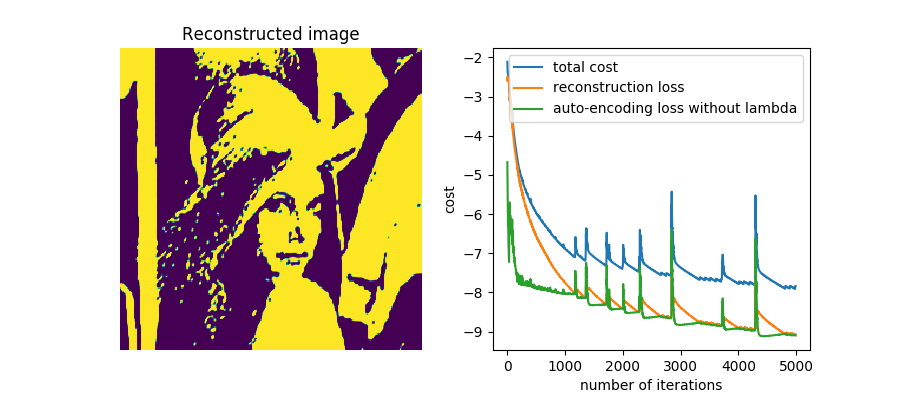

In [4]:
%matplotlib notebook
fig = plt.figure(figsize=(9,4),dpi=100)
ax2 = fig.add_subplot(1,2,1)
ax3 = fig.add_subplot(1,2,2)


In [5]:
import time
import random
import scipy.io

num_iter = 5000
cost_hist = np.zeros([num_iter,3])
start_time = time.time()
time_hist = np.zeros([num_iter,1])

sc = 255.0

# making mask tensor from an input image
msk = np.where(img==0,0.0,1.0)

# reshape
label_data = np.transpose(np.reshape(img.astype(np.float32),[1,N1,N2,N3])/sc)
mask_data  = np.transpose(np.reshape(msk.astype(np.float32),[1,N1,N2,N3]))

lam = 5.0 # initial value of lambda (this is adjustable)
with tf.Session(config=config) as sess:
    sess.run(init)
    print('Iinitialized!')
    for step in range(0,num_iter):
        _, cost_value,cost_rec,cost_ae, y_est, x_est = sess.run([update,cost,rec_loss,ae_loss,Y,X],{label_node:label_data,mask_node:mask_data,lam_ph:lam})
        l_rate = sess.run(learning_rate)
        cost_hist[step,0] = cost_value
        cost_hist[step,1] = cost_rec
        cost_hist[step,2] = cost_ae/lam
        time_hist[step] = time.time() - start_time
        if step %10 == 0:
            elapsed_time = time.time() - start_time
            if cost_rec < cost_ae/lam:
                lam = lam*1.1
            elif cost_ae/lam < cost_rec:
                lam = lam*0.99
            print('Step %d / %d :: %f :: %f :: %f ' % (step,num_iter,cost_value,l_rate,lam))
            ax2.clear()
            ax2.imshow(np.transpose(np.reshape(255.0*y_est,[N2,N1])).astype(np.uint8))
            ax2.set_title("Reconstructed image")
            ax2.axis("off")
            ax3.clear()
            ax3.plot(np.log(cost_hist[0:step,0]), label="total cost")
            ax3.plot(np.log(cost_hist[0:step,1]), label="reconstruction loss")
            ax3.plot(np.log(cost_hist[0:step,2]), label="auto-encoding loss without lambda")
            ax3.legend()
            ax3.set_xlabel("number of iterations")
            ax3.set_ylabel("cost")
            fig.canvas.draw()
            numstr = '%05d' % step
imageio.imsave('output_IP_binary.png',np.transpose(np.reshape(255.0*y_est,[N2,N1])).astype(np.uint8))

Iinitialized!
Step 0 / 5000 :: 0.121046 :: 0.010000 :: 4.950000 
Step 10 / 5000 :: 0.088608 :: 0.010000 :: 4.900500 
Step 20 / 5000 :: 0.080589 :: 0.010000 :: 4.851495 
Step 30 / 5000 :: 0.069868 :: 0.010000 :: 4.802980 
Step 40 / 5000 :: 0.056131 :: 0.010000 :: 4.754950 
Step 50 / 5000 :: 0.049565 :: 0.010000 :: 4.707401 
Step 60 / 5000 :: 0.043834 :: 0.010000 :: 4.660327 
Step 70 / 5000 :: 0.038772 :: 0.010000 :: 4.613723 
Step 80 / 5000 :: 0.033145 :: 0.010000 :: 4.567586 
Step 90 / 5000 :: 0.028017 :: 0.010000 :: 4.521910 
Step 100 / 5000 :: 0.023999 :: 0.009800 :: 4.476691 
Step 110 / 5000 :: 0.020409 :: 0.009800 :: 4.431924 
Step 120 / 5000 :: 0.017829 :: 0.009800 :: 4.387605 
Step 130 / 5000 :: 0.015871 :: 0.009800 :: 4.343729 
Step 140 / 5000 :: 0.014257 :: 0.009800 :: 4.300292 
Step 150 / 5000 :: 0.012850 :: 0.009800 :: 4.257289 
Step 160 / 5000 :: 0.011597 :: 0.009800 :: 4.214716 
Step 170 / 5000 :: 0.010493 :: 0.009800 :: 4.172569 
Step 180 / 5000 :: 0.009560 :: 0.009800 :: 

Step 1540 / 5000 :: 0.000794 :: 0.007386 :: 1.981391 
Step 1550 / 5000 :: 0.000785 :: 0.007386 :: 1.961577 
Step 1560 / 5000 :: 0.000777 :: 0.007386 :: 1.941961 
Step 1570 / 5000 :: 0.000769 :: 0.007386 :: 1.922541 
Step 1580 / 5000 :: 0.000759 :: 0.007386 :: 1.903316 
Step 1590 / 5000 :: 0.000752 :: 0.007386 :: 1.884283 
Step 1600 / 5000 :: 0.000744 :: 0.007238 :: 1.865440 
Step 1610 / 5000 :: 0.000736 :: 0.007238 :: 1.846786 
Step 1620 / 5000 :: 0.000729 :: 0.007238 :: 1.828318 
Step 1630 / 5000 :: 0.000720 :: 0.007238 :: 1.810035 
Step 1640 / 5000 :: 0.000712 :: 0.007238 :: 1.791934 
Step 1650 / 5000 :: 0.000705 :: 0.007238 :: 1.774015 
Step 1660 / 5000 :: 0.000698 :: 0.007238 :: 1.756275 
Step 1670 / 5000 :: 0.000696 :: 0.007238 :: 1.738712 
Step 1680 / 5000 :: 0.000684 :: 0.007238 :: 1.721325 
Step 1690 / 5000 :: 0.000677 :: 0.007238 :: 1.704112 
Step 1700 / 5000 :: 0.000671 :: 0.007093 :: 1.687070 
Step 1710 / 5000 :: 0.000665 :: 0.007093 :: 1.855778 
Step 1720 / 5000 :: 0.001086

Step 3060 / 5000 :: 0.000596 :: 0.005455 :: 2.578677 
Step 3070 / 5000 :: 0.000589 :: 0.005455 :: 2.552891 
Step 3080 / 5000 :: 0.000584 :: 0.005455 :: 2.527362 
Step 3090 / 5000 :: 0.000578 :: 0.005455 :: 2.502088 
Step 3100 / 5000 :: 0.000573 :: 0.005346 :: 2.477067 
Step 3110 / 5000 :: 0.000567 :: 0.005346 :: 2.452297 
Step 3120 / 5000 :: 0.000562 :: 0.005346 :: 2.427774 
Step 3130 / 5000 :: 0.000556 :: 0.005346 :: 2.403496 
Step 3140 / 5000 :: 0.000551 :: 0.005346 :: 2.379461 
Step 3150 / 5000 :: 0.000547 :: 0.005346 :: 2.355666 
Step 3160 / 5000 :: 0.000542 :: 0.005346 :: 2.332110 
Step 3170 / 5000 :: 0.000537 :: 0.005346 :: 2.308789 
Step 3180 / 5000 :: 0.000532 :: 0.005346 :: 2.285701 
Step 3190 / 5000 :: 0.000526 :: 0.005346 :: 2.262844 
Step 3200 / 5000 :: 0.000522 :: 0.005239 :: 2.240215 
Step 3210 / 5000 :: 0.000517 :: 0.005239 :: 2.217813 
Step 3220 / 5000 :: 0.000512 :: 0.005239 :: 2.195635 
Step 3230 / 5000 :: 0.000508 :: 0.005239 :: 2.173679 
Step 3240 / 5000 :: 0.000503

Step 4580 / 5000 :: 0.000454 :: 0.004029 :: 2.718372 
Step 4590 / 5000 :: 0.000450 :: 0.004029 :: 2.691189 
Step 4600 / 5000 :: 0.000446 :: 0.003948 :: 2.664277 
Step 4610 / 5000 :: 0.000442 :: 0.003948 :: 2.637634 
Step 4620 / 5000 :: 0.000438 :: 0.003948 :: 2.611258 
Step 4630 / 5000 :: 0.000434 :: 0.003948 :: 2.585145 
Step 4640 / 5000 :: 0.000431 :: 0.003948 :: 2.559294 
Step 4650 / 5000 :: 0.000426 :: 0.003948 :: 2.533701 
Step 4660 / 5000 :: 0.000422 :: 0.003948 :: 2.508364 
Step 4670 / 5000 :: 0.000418 :: 0.003948 :: 2.483280 
Step 4680 / 5000 :: 0.000415 :: 0.003948 :: 2.458447 
Step 4690 / 5000 :: 0.000411 :: 0.003948 :: 2.433863 
Step 4700 / 5000 :: 0.000408 :: 0.003869 :: 2.409524 
Step 4710 / 5000 :: 0.000404 :: 0.003869 :: 2.385429 
Step 4720 / 5000 :: 0.000401 :: 0.003869 :: 2.361575 
Step 4730 / 5000 :: 0.000397 :: 0.003869 :: 2.337959 
Step 4740 / 5000 :: 0.000394 :: 0.003869 :: 2.314579 
Step 4750 / 5000 :: 0.000390 :: 0.003869 :: 2.291434 
Step 4760 / 5000 :: 0.000387